# Discovering Computable Math on the Web

In [173]:
import re
from operator import is_not
from functools import partial, lru_cache

from sympy import init_printing
from sympy.plotting import plot
from latex2sympy import process_sympy
from pyquery import PyQuery
from notebook.utils import url_path_join as ujoin

We're going to do some scraping... at least do _some_ caching.

In [177]:
@lru_cache(maxsize=128)
def pq(url):
    return PyQuery(url)

There's a lot of crazy Latex out there, and a lot of math that `latex2sympy` can't parse yet, so here's a helper function to winnow that down some.

[This PR](https://github.com/augustt198/latex2sympy/pull/38) handles the various style expressions!

In [178]:
STYLE_RE = r'{\\(display|text|script)style (.*)\}'

In [179]:
def parses(raw):
    match = re.match(STYLE_RE, raw, re.M)
    
    if match is not None:
        raw = match[2]
    try:
        return process_sympy(raw)
    except:
        pass

Wikipedia (or any other MediaWiki page with the [Math](https://www.mediawiki.org/wiki/Extension:Math) extension.

> _TODO: How might we search for MediaWiki pages that use a given extension?_

Here are some URLs and HTML selectors that have lots of neat stuff.

In [180]:
WIKIPEDIA = "https://en.wikipedia.org/wiki"
MEDIAWIKI_SELECTOR = ".mwe-math-fallback-image-inline[alt]"
MATH_WIKI = "http://math.wikia.com/wiki"
WIKIA_SELECTOR = ".tex[alt]"

In [181]:
def wiki_maths(topic, wiki=WIKIPEDIA, selector=MEDIAWIKI_SELECTOR, attrib="alt"):
    url = ujoin(wiki, topic.replace(" ", "_"))
    return list(filter(partial(is_not, None), [
        parses(img.attrib[attrib])
        for img in pq(url)(selector)
    ]))

# 🚀 Rockets

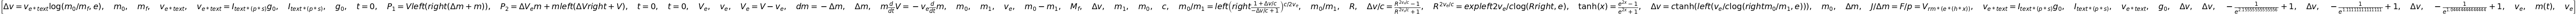

In [183]:
wiki_maths("Tsiolkovsky rocket equation")

# Some advanced applied concepts

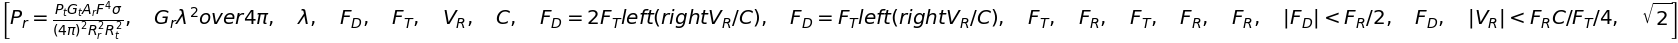

In [184]:
wiki_maths("Radar")

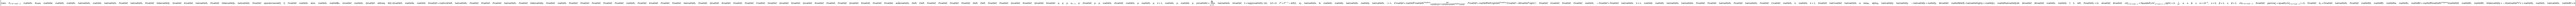

In [185]:
wiki_maths("Kalman filter")

# More Math

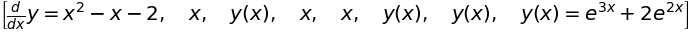

In [186]:
wiki_maths("Differential equation", MATH_WIKI, WIKIA_SELECTOR)

# Math in Jupyter Markdown
The Jupyter Notebook uses Jupyter Markdown, which is a subset of [Github-flavored Markdown](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#GitHub-flavored-markdown) plus [inline and block math](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations), wrapped in `$` or `$$`. You can drop a bit of the URL for [nbviewer](https://nbviewer.org) in this function and see all the defined equations from a notebook.

In [191]:
def notebook_math(nbviewer_fragment):
    url = ujoin("https://nbviewer.jupyter.org", nbviewer_fragment)
    r = requests.get(url)
    matches = sum([
        re.findall(r'\$\$(.*?)\$\$', p.text, flags=re.M) 
        for p in pq(url)("p") if p.text
    ], [])
    return list(filter(partial(is_not, None), [
        parses(match)
        for match in matches
    ]))

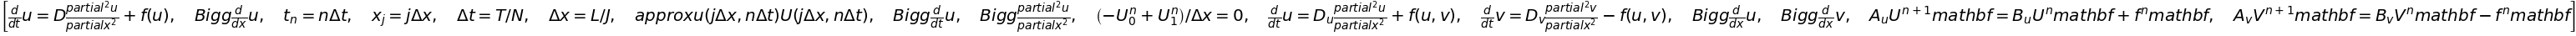

In [190]:
notebook_math("github/waltherg/notebooks/blob/master/2013-12-03-Crank_Nicolson.ipynb")